**DSCI 100 Final Project: Predicting Usage of a Video Game Research Server**

**Title: Predicting Minecraft Hours Played From Age Using K-Nearest Neighbors Regression**

In the Computer Science Department at UBC, Dr. Frank Wood opened a Minecraft server to examine how people play videos games. Minecraft is a popular video game, developped in 2009, that allows players to explore, build, and create in a randomly-generated terrain made of voxels. From this server, two datasets hsve been generated, including the one used in this project: players.csv. 

For this final project, I would like to know which "kinds" of players are most likely to contribute a large amount of data so that others can target those players in their recruiting efforts. Specifically, I want to know: *can we predict minecraft playing time based on age using the 'players.csv' dataset?*

Let's start by installing/loading the proper libraries and reading in the datafile.


In [ ]:
#loading libraries for analyses - to install, use install.packages()!
library(tidyverse)
library(readr)
library(tidymodels)
library(scales)
library(janitor)

#preset the max rows shown when displaying data
options(repr.matrix.max.rows = 6)

In [55]:
#find working directory
getwd()

#read in the appropriate dataset called players.csv using a relative path and
#cleaning col names to remove uneccessary capitals
players <- read_delim('Data/players.csv', delim = ',', skip = 1 ) 
players

[1] "/home/jovyan/work/dsci-100-2025-LM-project"

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Let's break down the variables in this dataset.
We have:
- 196 observations (Individual players)
- 7 variables ('experience', 'subscribe', 'hashed_email', 'played_hours', 'name', 'gender', and 'age')

Of these variables, we have:
1. Experience: This designates experience level of the player. While it ids labeled as a character, we cold use it s a factor. This variable will not be included in the following analyses.
2. Subscribe: This logic variable tells us wheter the player subscribed to a video-game-related newsletter. This variable will not be included in the following analyses.
3. Hashed Email: A character string related to the player's email. This variable will not be included in the following analyses.
4. **Played Hours (played_hours): A Double (dbl) variable showing the total sum of hours a player spent on the Minecraft server. We will be using this variable in our analyses.**
5. Name: A character string detailing each player's first name. This variable will not be included in the following analyses.
6. Gender: A categorical (fct) variable giving the gender of each player. While shown as a character, if used, would hsave to be trabsformed into a fct data type.his variable will not be included in the following analyses.
7. **Age: A double data type variable telling us the age (in years) of each player. We will be using this variable in our analyses.**

Variables used in this analyses are displayed in **bold**. 

Now that we have defined the variables, let's tale a look at our variables of interest and their distributions/summaries. I will also see if we have any NAs to deal with later in the analyses.

[1] 2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


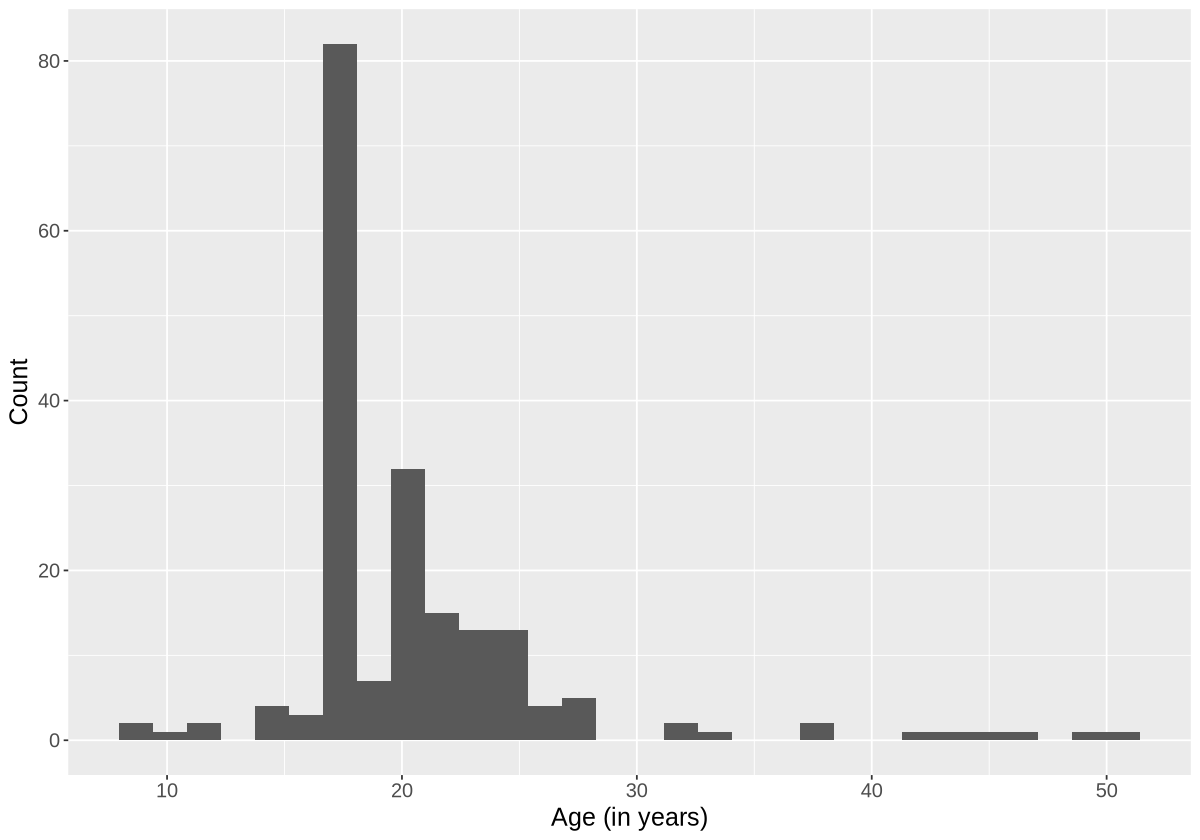

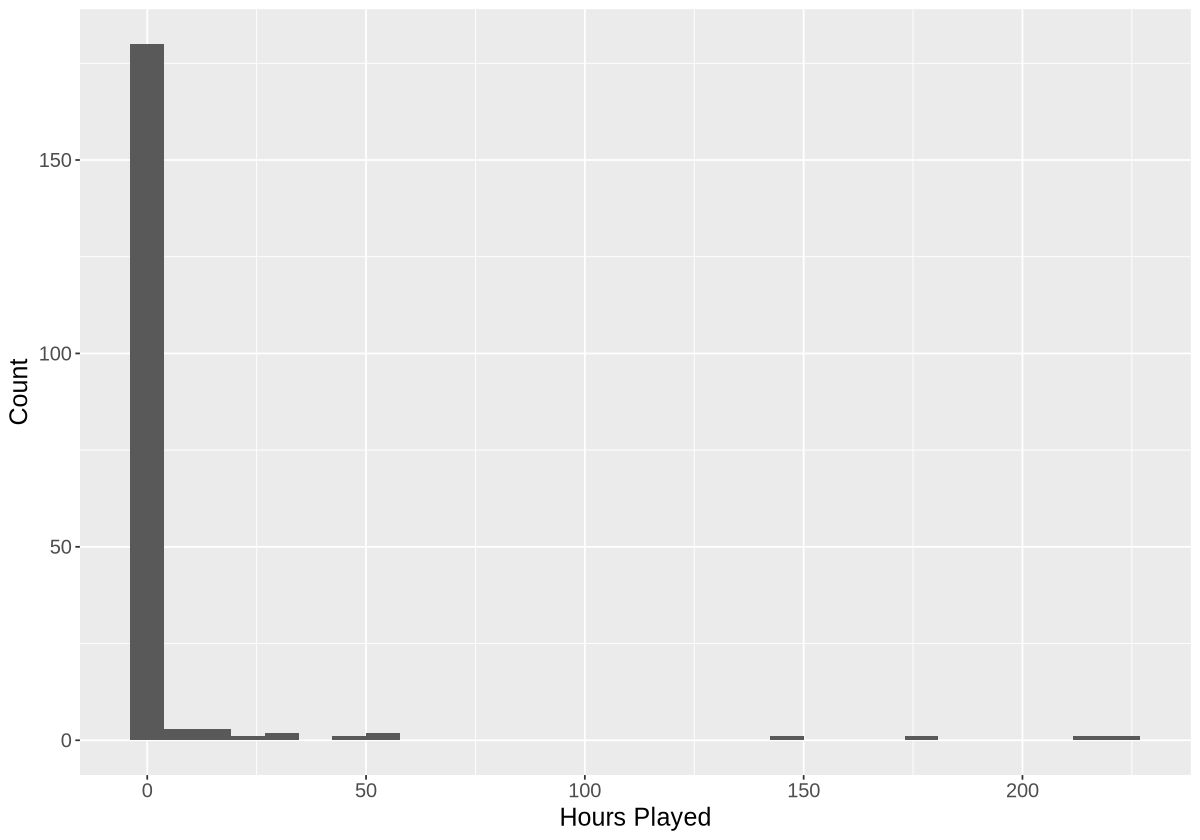

In [68]:
#checking for NAs in our dataset
sum(is.na(players))

#plotting age and played_hours distributions

age_histogram <- players |> ggplot(aes(x = age)) + geom_histogram() + ylab("Count") + xlab("Age (in years)") + 
    theme(text = element_text(size = 15))
age_histogram

played_hrs_histogram <- players |> ggplot(aes(x = played_hours)) + geom_histogram() + ylab("Count") + xlab("Hours Played") + 
    theme(text = element_text(size = 15))
played_hrs_histogram

In [69]:
#summary of the dataset

summary(players, age)

  experience        subscribe       hashed_email        played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               age       
 Length:196         Length:196         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.52  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  
                               

Limitations of this dataset:
This dataset, collected at UBC, holds unique characteristics that may not hold true to other Minecraft server datasets.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


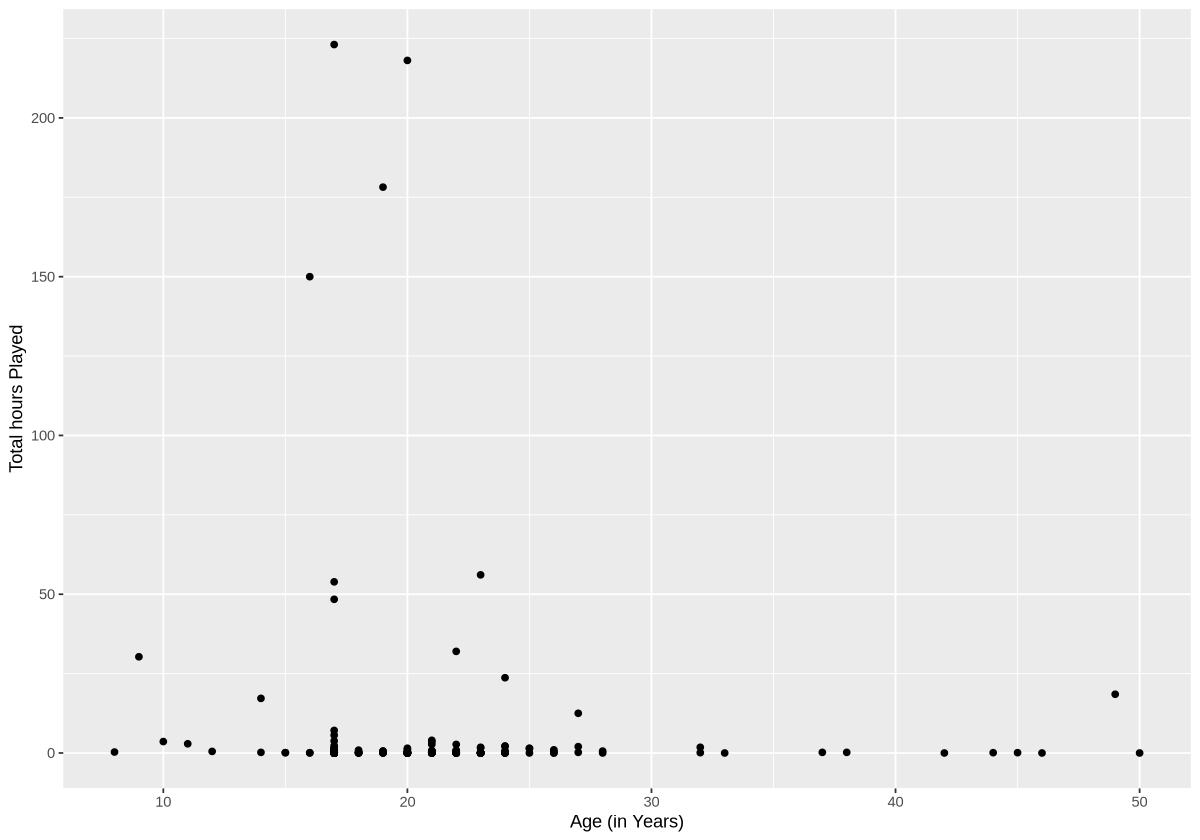

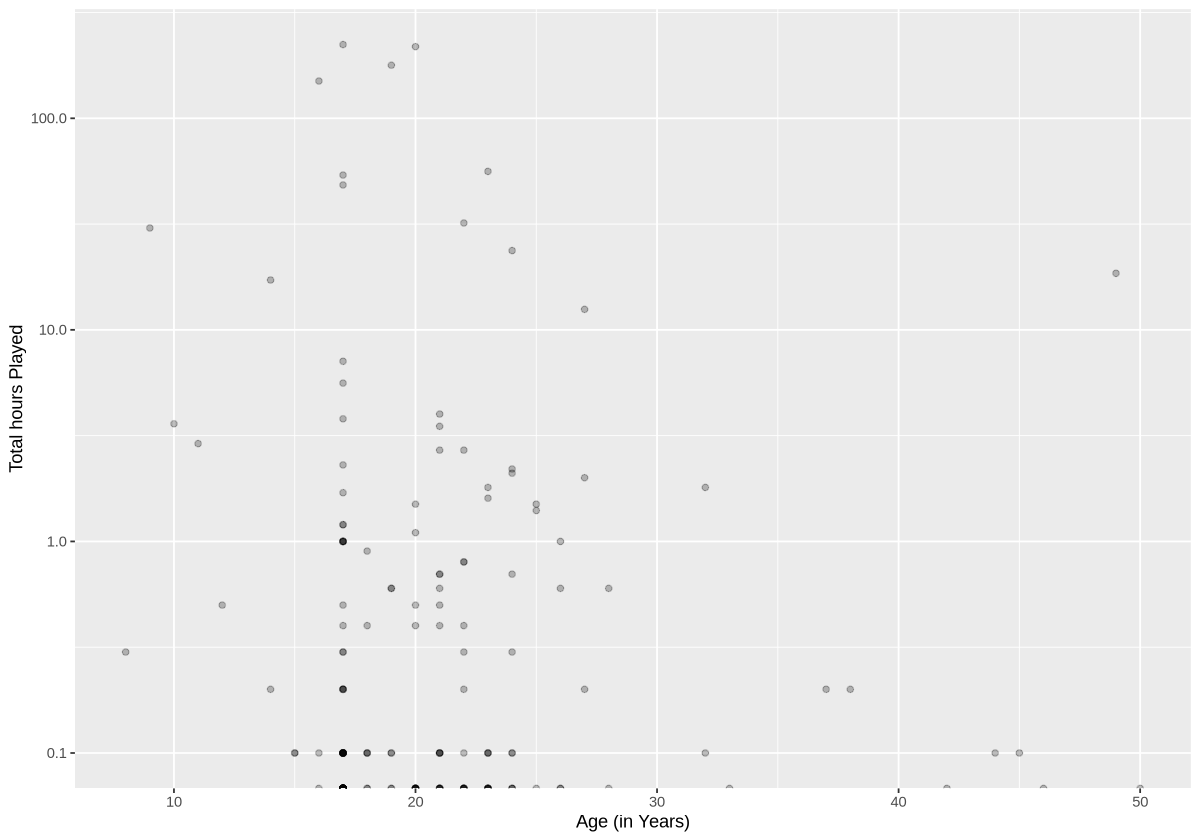

In [3]:
#setting dimensions for the plots
options(repr.plot.length = 10, repr.plot.width = 10)

#Exploratory plots to better understand the dataset 
playr_time_age_plot <- players |> ggplot(aes(x = age, 
                            y = played_hours)) +
                    geom_point() +  
                    labs(color = "Did the player subscribe?") +
                    ylab("Total hours Played") + xlab("Age (in Years)")

playr_time_age_plot 

#we see a lot of points near the x-axis, causing some overplotting losing detail - I created a 'zoomed-in' graph 
#to better examine these data points
playr_time_age_plot_scaled <- players |> ggplot(aes(x = age, 
                            y = played_hours)) +
                    geom_point(alpha = 0.25) +  scale_y_log10() +
                    labs(color = "Did the player subscribe?") +
                    ylab("Total hours Played") + xlab("Age (in Years)")

playr_time_age_plot_scaled

#here we can see that most points are below 10 hours played 
#and below 30 years (which makes sense for an undergraduate course)
#We also see that the data does not visibly appear to have any linearity, 
#so we should likely use a KNN regression rather than a simple linear regression to
#try to predict played hours based on age

Let's clean the data to answer this specific research question, removing uneccessary variables and removing NAs.

In [8]:
players_knn <- players |> select(age, played_hours) |> na.omit()
players_knn

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
⋮,⋮
22,0.3
17,0.0
17,2.3


Now we will try to build a KNN regression model for our research question and then undergo cross validation to find the best K value. We will split the data first into a 75/25 split.

In [9]:
#splitting the training and testing set
knn_split <- initial_split(players_knn, prop = 0.75, strata = played_hours)
knn_training <- training(knn_split)
knn_testing <- testing(knn_split)

In [33]:
#building the model and recipe (e.g.,standardizing) for tuning
knn_recipe <- recipe(played_hours ~ age, data = knn_training) |> step_center(all_predictors()) |>
    step_scale(all_predictors())
tune_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> set_engine('kknn') |>
    set_mode('regression')

In [34]:
set.seed(1010) 
#for the purposes of consistency (for grading) I have preset the randomness - remove in real life circumstances!

#creating 5 v folds and performing cross validation to find the best K
vfolds <- vfold_cv(knn_training, v = 5, strata = played_hours)

best_k_wflw <- workflow() |> add_recipe(knn_recipe) |> add_model(tune_knn_spec) 

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

best_k_metrics <- best_k_wflw |> tune_grid(resamples = vfolds, grid = k_vals) |> collect_metrics() |> filter(.metric == 'rmse')

best_reg_k <- best_k_metrics |> slice_min(mean, n=1) |> select(neighbors) |> pull()
best_reg_k
##our best K for this KNN regression is K = 5


[1] 5

Now that we have found our best K value (5), we will create a new tuned model and test the  model on our test data.

In [44]:
knn_reg_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_reg_k) |> set_engine('kknn') |>
    set_mode('regression')

#testing the k-fitted regression model on our testing data
knn_reg_fit <- workflow() |> add_recipe(knn_recipe) |> add_model(knn_reg_spec) |> fit(knn_training)

#predicting the test data and assessing its RMPSE
knn_reg_test <- knn_reg_fit |> predict(knn_testing) |> 
        bind_cols(knn_testing) 
knn_reg_test
knn_reg_test_metrics <- knn_reg_fit |> predict(knn_testing) |> 
        bind_cols(knn_testing) |> metrics(truth = played_hours, estimate = .pred) |> filter(.metric =='rmse')
knn_reg_test_metrics

.pred,age,played_hours
<dbl>,<dbl>,<dbl>
1.50,9,30.3
0.04,17,3.8
0.04,21,0.1
⋮,⋮,⋮
3.72,44,0.1
0.04,17,0.0
0.04,17,0.0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,26.16949


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


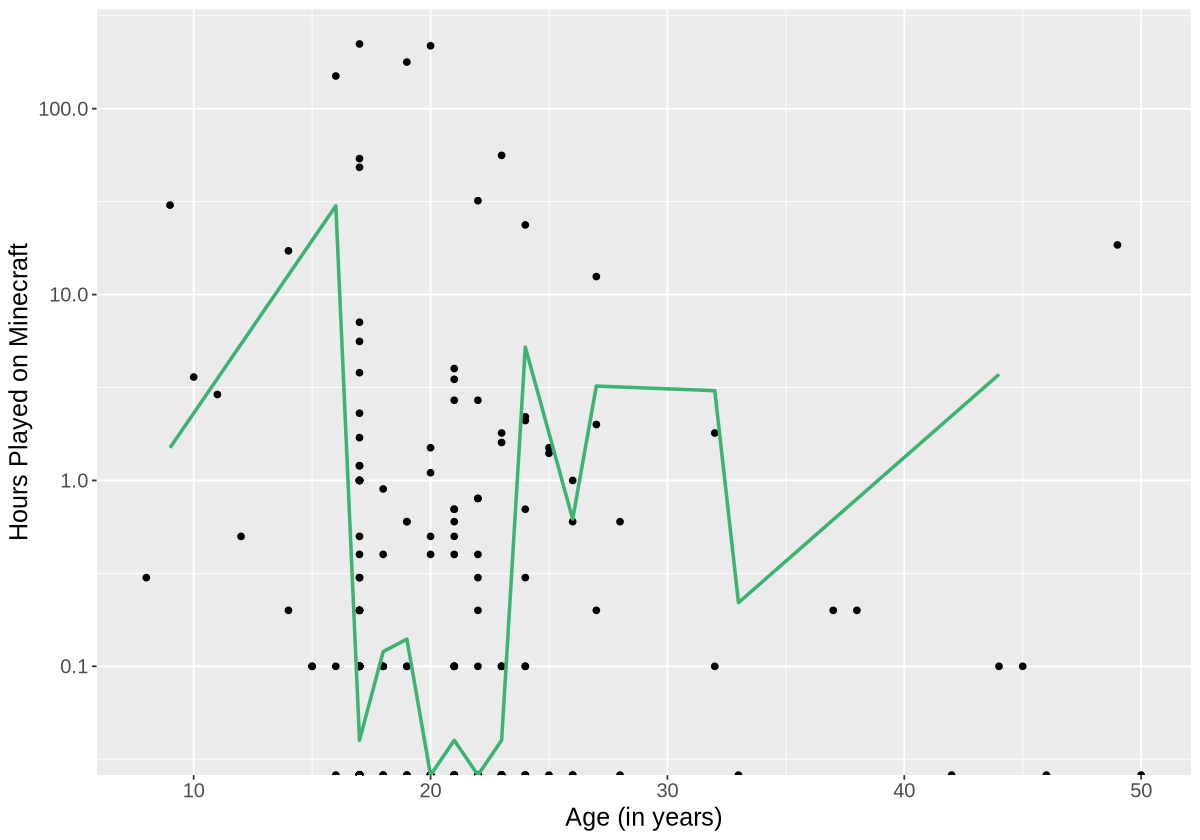

In [54]:
#Let's visualize these predictions through a plot

knn_reg_rmse_plot <- players_knn |> ggplot(aes(x = age, y = played_hours)) + geom_point() + 
        geom_line(data = knn_reg_test, mapping = aes(x = age, y = .pred), linewidth = 1, color = 'mediumseagreen') +
        scale_y_log10() + ylab("Hours Played on Minecraft") + xlab("Age (in years)") + 
        theme(text = element_text(size = 15))

knn_reg_rmse_plot

Based on this plot and the RMSPE, we can tell that the KNN regression model is not operating in a helpful way. This is likely due to the distribution of data, wherein there are many playersin the 20-30 year range and little data points in other ranges. This limits the model's ability to predict at extremes, as the KNN model starts to grab the same data points.